<h1>¿Podemos mejorar la predicción de los tiempo de ciclo?</h1>

In [1]:
#importar librerias
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import modulo_conn_sql as mcq

In [2]:
#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

#SQL Methods to get operation data
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

In [3]:
def graficar_dispersion( componente, cota_inferior, cota_superior ):
    #cuento las repeticiones por cada componente
    df_count_time = df[(df[componente] < cota_superior) & (df[componente] > cota_inferior)].groupby([componente])['Entrega'].agg(['count']).reset_index()
    #grafico la dispersión de los datos
    plt.figure(figsize=(18,7))
    plt.scatter(df_count_time[componente], df_count_time['count'])
    plt.title("Dispersión tiempos")
    plt.xlabel(componente)
    plt.ylabel("Repeticiones")

In [4]:
#parametros
pais = 'Colombia'
dias = 90

#Dataframe con los despachos
df = querySQL( "{CALL SCAC_AP10_dataset_servicios (?,?)}" , (pais, dias) )

#filtro las entregas realizadas, es decir elimino cancelaciones y demás
df = df[(df['Entrega'] != '') & (df['Estatus'] == 'Normal') ]

In [6]:
df.head().T

,0,1,2,3,4
Pedido,8011704416-P,8011704416-P,8011704416-P,8011704416-P,8011704416-P
servicio,L001,L002,L003,L004,L005
Entrega,200751198,200751200,200752381,200752398,200752401
Estatus,Normal,Normal,Normal,Normal,Normal
EstatusPedido,En proceso - Cabecera,En proceso - Cabecera,En proceso - Cabecera,En proceso - Cabecera,En proceso - Cabecera
Cluster,CLUSTER COSTA,CLUSTER COSTA,CLUSTER COSTA,CLUSTER COSTA,CLUSTER COSTA
Planta,CO-PLANTA CARTAGENA,CO-PLANTA CARTAGENA,CO-PLANTA CARTAGENA,CO-PLANTA CARTAGENA,CO-PLANTA CARTAGENA
TipoPlanta,Central,Central,Central,Central,Central
Ciudad,Cartagena,Cartagena,Cartagena,Cartagena,Cartagena
Centro,F020,F020,F020,F020,F020


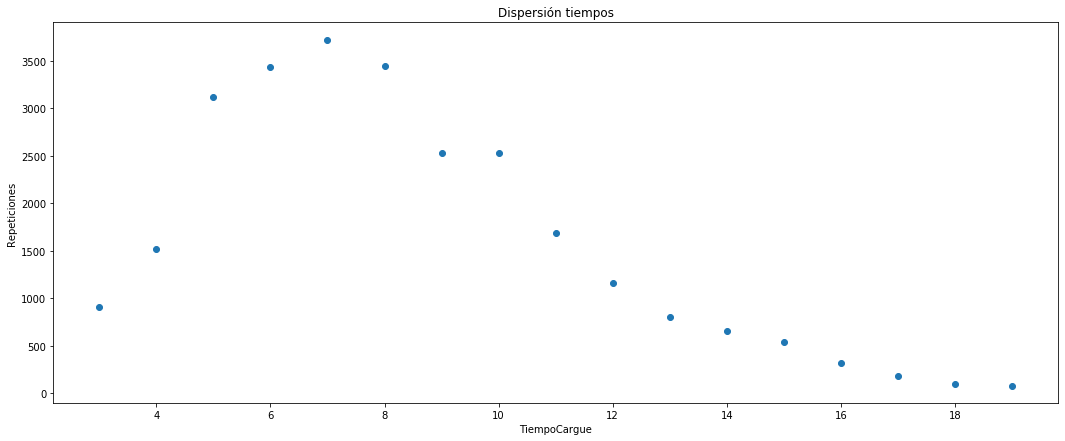

In [6]:
graficar_dispersion('TiempoCargue', 2, 20)

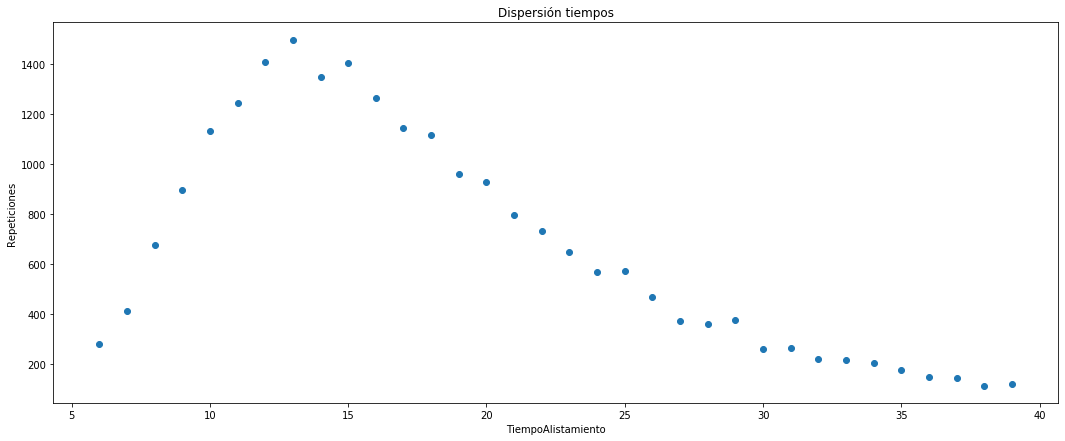

In [7]:
graficar_dispersion('TiempoAlistamiento', 5, 40)

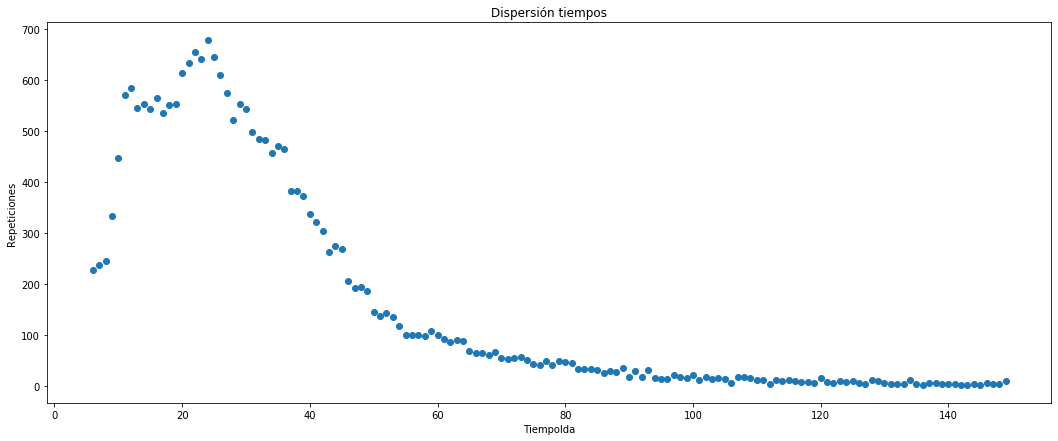

In [8]:
graficar_dispersion('TiempoIda', 5, 150)

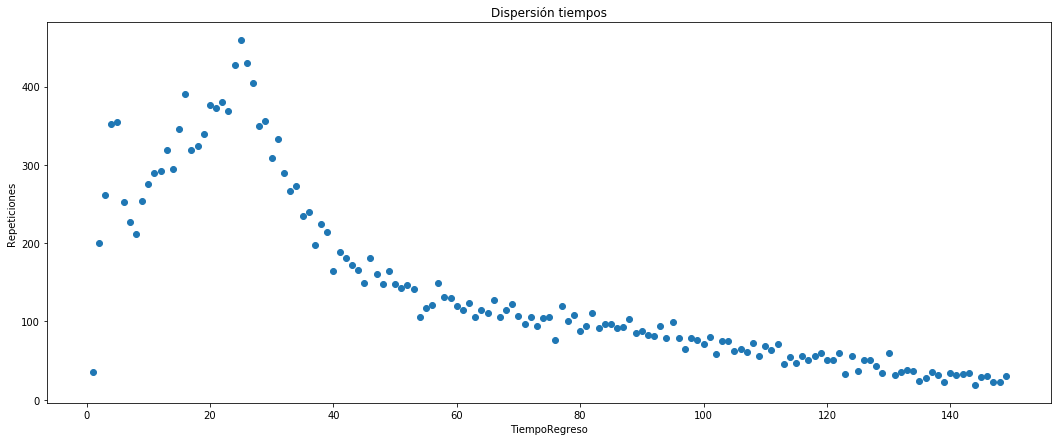

In [9]:
graficar_dispersion('TiempoRegreso', 0, 150)

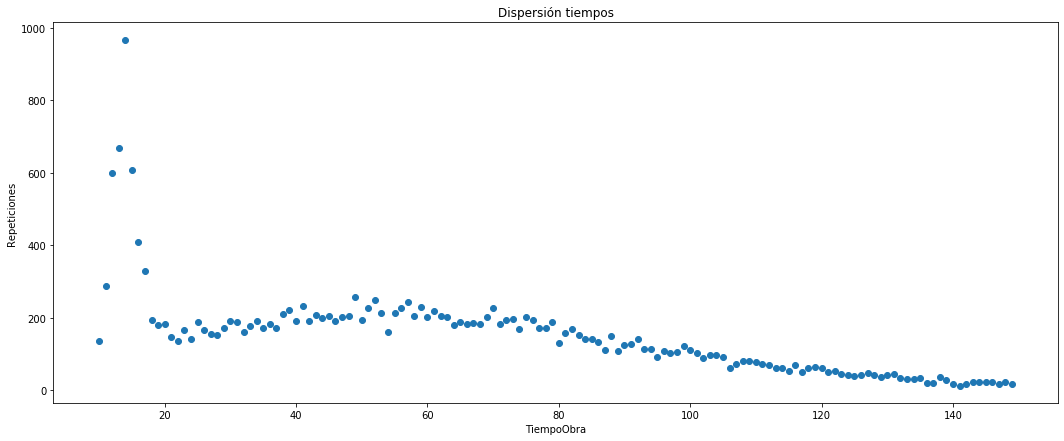

In [10]:
graficar_dispersion('TiempoObra', 0, 150)

In [11]:
#Dataframe tabla con los componentes
df_componentes = querySQL( "select * from AV37_Componentes_Ciclo_Malla_Turnos_Clientes_Tabla" , () )

In [12]:
#analisis de error absoluto
df_1 = pd.merge(df, df_componentes, how='left', left_on=['Planta', 'Obra'], right_on=['Planta', 'Cliente'])
df_1 = df_1[(df_1['Entrega']!= '') & (df_1['Estatus'] == 'Normal')]
df_1 = df_1.fillna(value=np.nan)
df_1 = df_1.drop(['Cliente_y'], axis=1)

df_1['eTiempoCargue'] = ((df_1['TiempoCargue'] - df_1['T.Cargue']).abs()) / df_1['TiempoCargue']
df_1['eTiempoAlistamiento'] = ((df_1['TiempoAlistamiento'] - df_1['T.Planta']).abs()) / df_1['TiempoAlistamiento']
df_1['eTiempoIda'] = ((df_1['TiempoIda'] - df_1['T.Ida']).abs()) / df_1['TiempoIda']
df_1['eTiempoObra'] = ((df_1['TiempoObra'] - df_1['T.Obra']).abs()) / df_1['TiempoObra']
df_1['eTiempoRegreso'] = ((df_1['TiempoRegreso'] - df_1['T.Regreso']).abs()) / df_1['TiempoRegreso']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

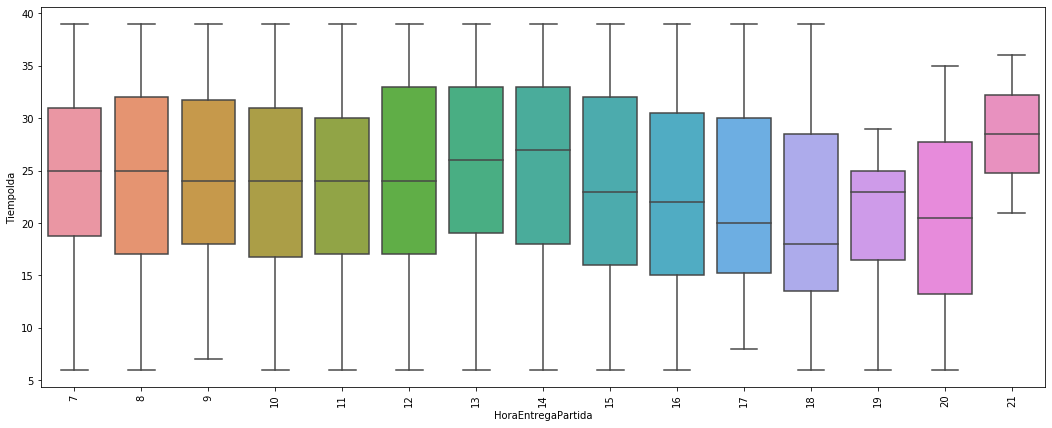

In [13]:
plt.figure(figsize=(18,7))
sns.boxplot(x='HoraEntregaPartida', y = 'TiempoIda', data = df_1[(df_1['TiempoIda'] > 5) & (df_1['TiempoIda'] < 40) & (df_1['Cluster'] == "CLUSTER ANTIOQUIA") ])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text xticklabel objects>)

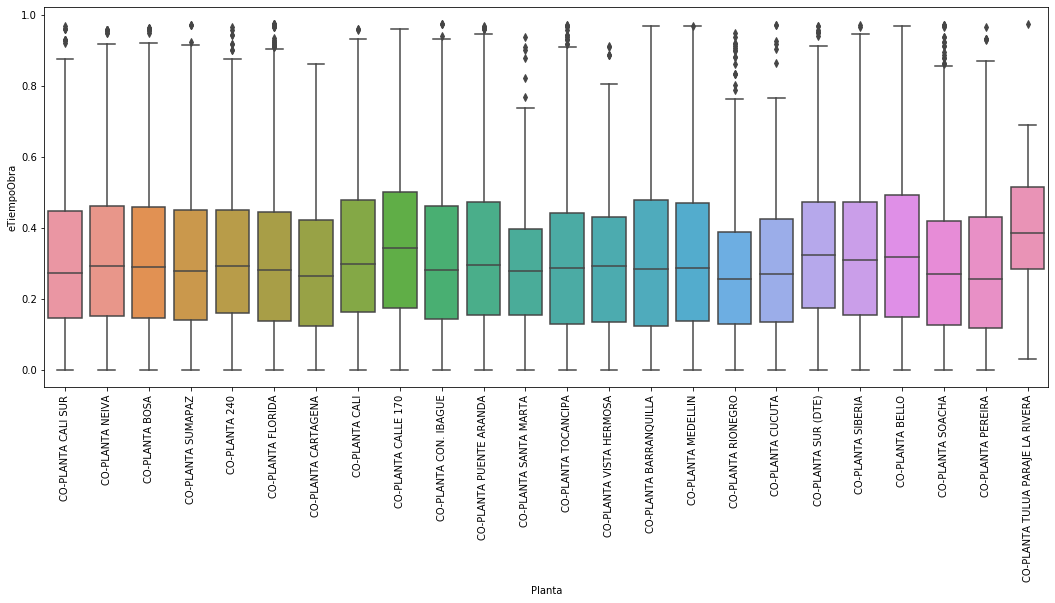

In [14]:
plt.figure(figsize=(18,7))
sns.boxplot(x='Planta', y = 'eTiempoObra', data = df_1[(df_1['TiempoObra'] > 10) & (df_1['TiempoObra'] < 180) & (df_1['eTiempoObra'] < 1)])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

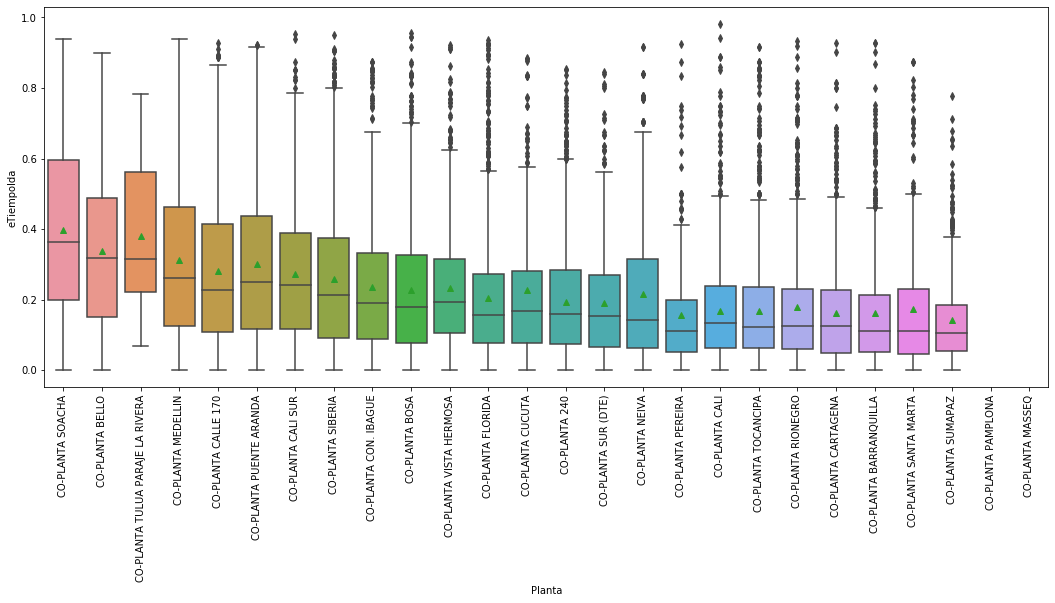

In [72]:
plt.figure(figsize=(18,7))
rank = df_1.groupby('Planta')['eTiempoIda'].median().fillna(0).sort_values()[::-1].index
sns.boxplot(x='Planta', y = 'eTiempoIda', data = df_1[(df_1['TiempoIda'] > 5) & (df_1['TiempoIda'] < 150) & (df_1['eTiempoIda'] < 1)], showmeans=True, order=rank)
plt.xticks(rotation=90)

<Figure size 1440x1440 with 0 Axes>

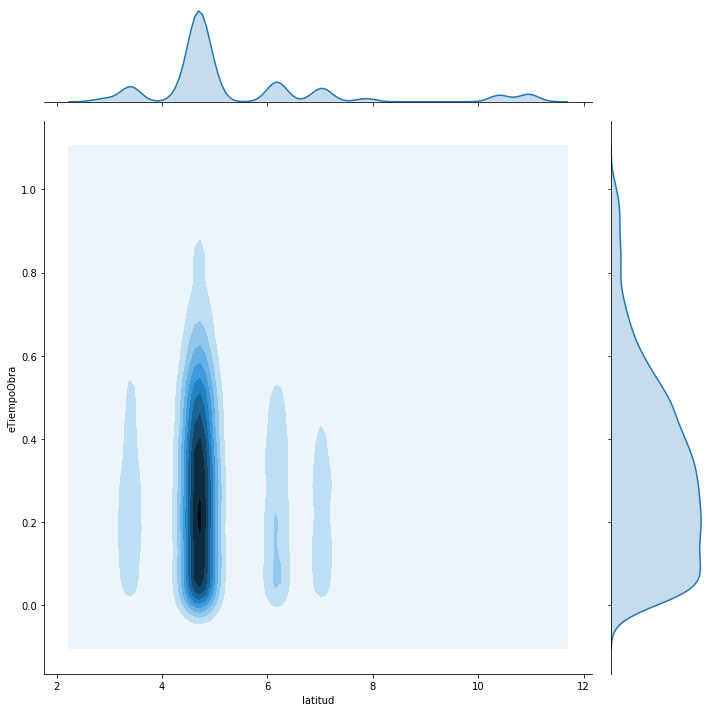

In [56]:
sns.jointplot(data = df_1[(df_1['TiempoObra'] < 150) & (df_1['eTiempoObra'] <= 1) & (df_1['DistanciaPlantaObraKm'] <= 25)], 
              x='latitud', 
              y = 'eTiempoObra', 
              kind='kde',
              height = 10   
             )

In [15]:
df_1['latitud_log'] = np.log(df_1['latitud'])

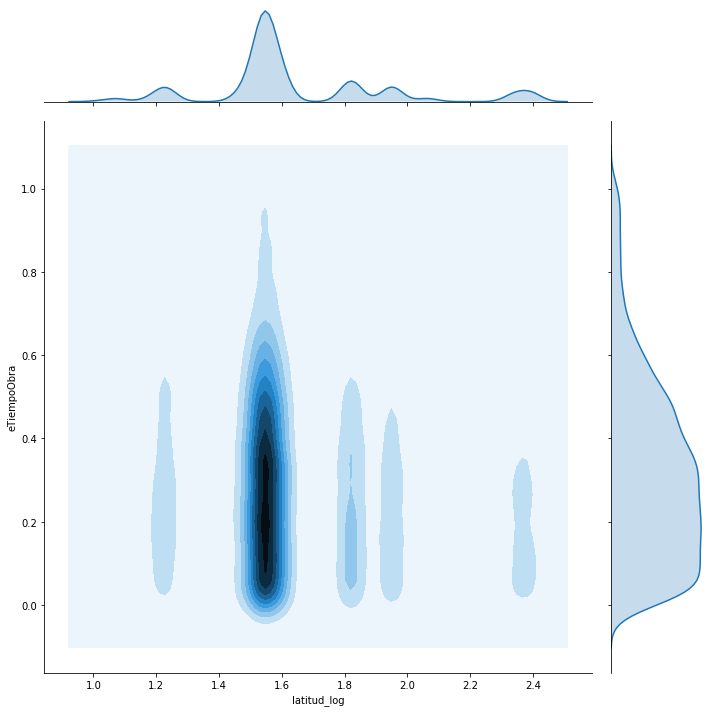

In [16]:
sns.jointplot(data = df_1[(df_1['TiempoObra'] < 150) & (df_1['eTiempoObra'] <= 1) & (df_1['DistanciaPlantaObraKm'] <= 25)], 
              x='latitud_log', 
              y = 'eTiempoObra', 
              kind='kde',
              height = 10   
             )

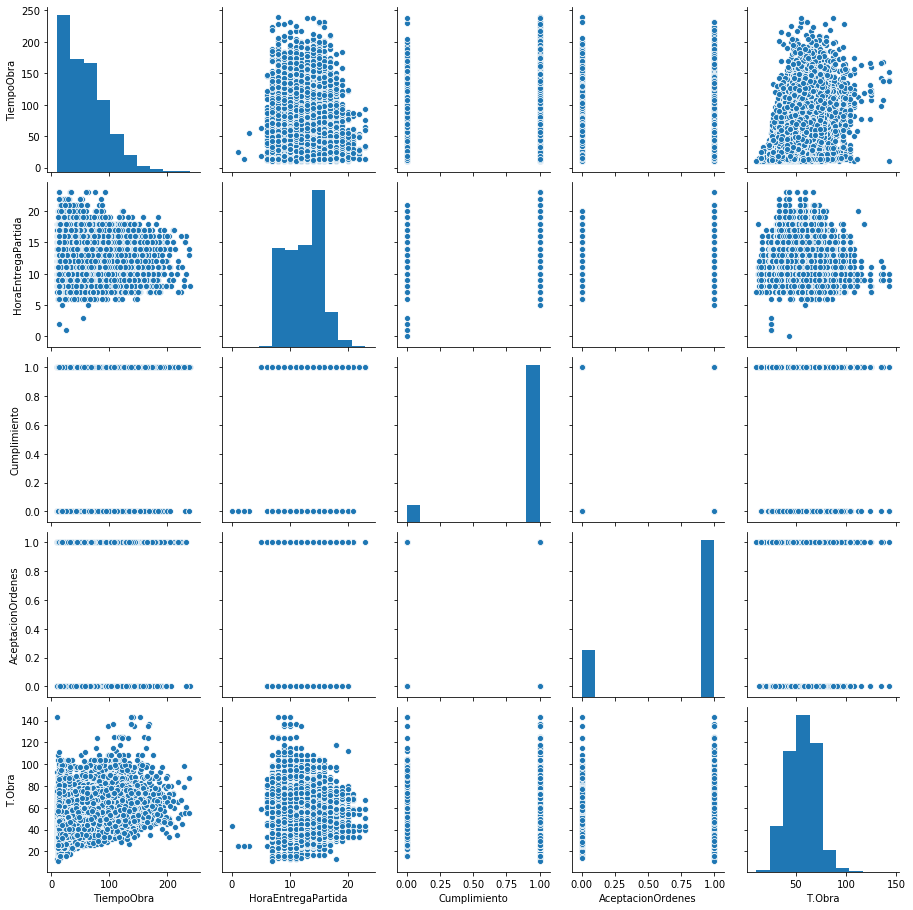

In [63]:
sns.pairplot(df_1[[ 'TiempoObra', "HoraEntregaPartida","Cumplimiento","AceptacionOrdenes", 'T.Obra']])

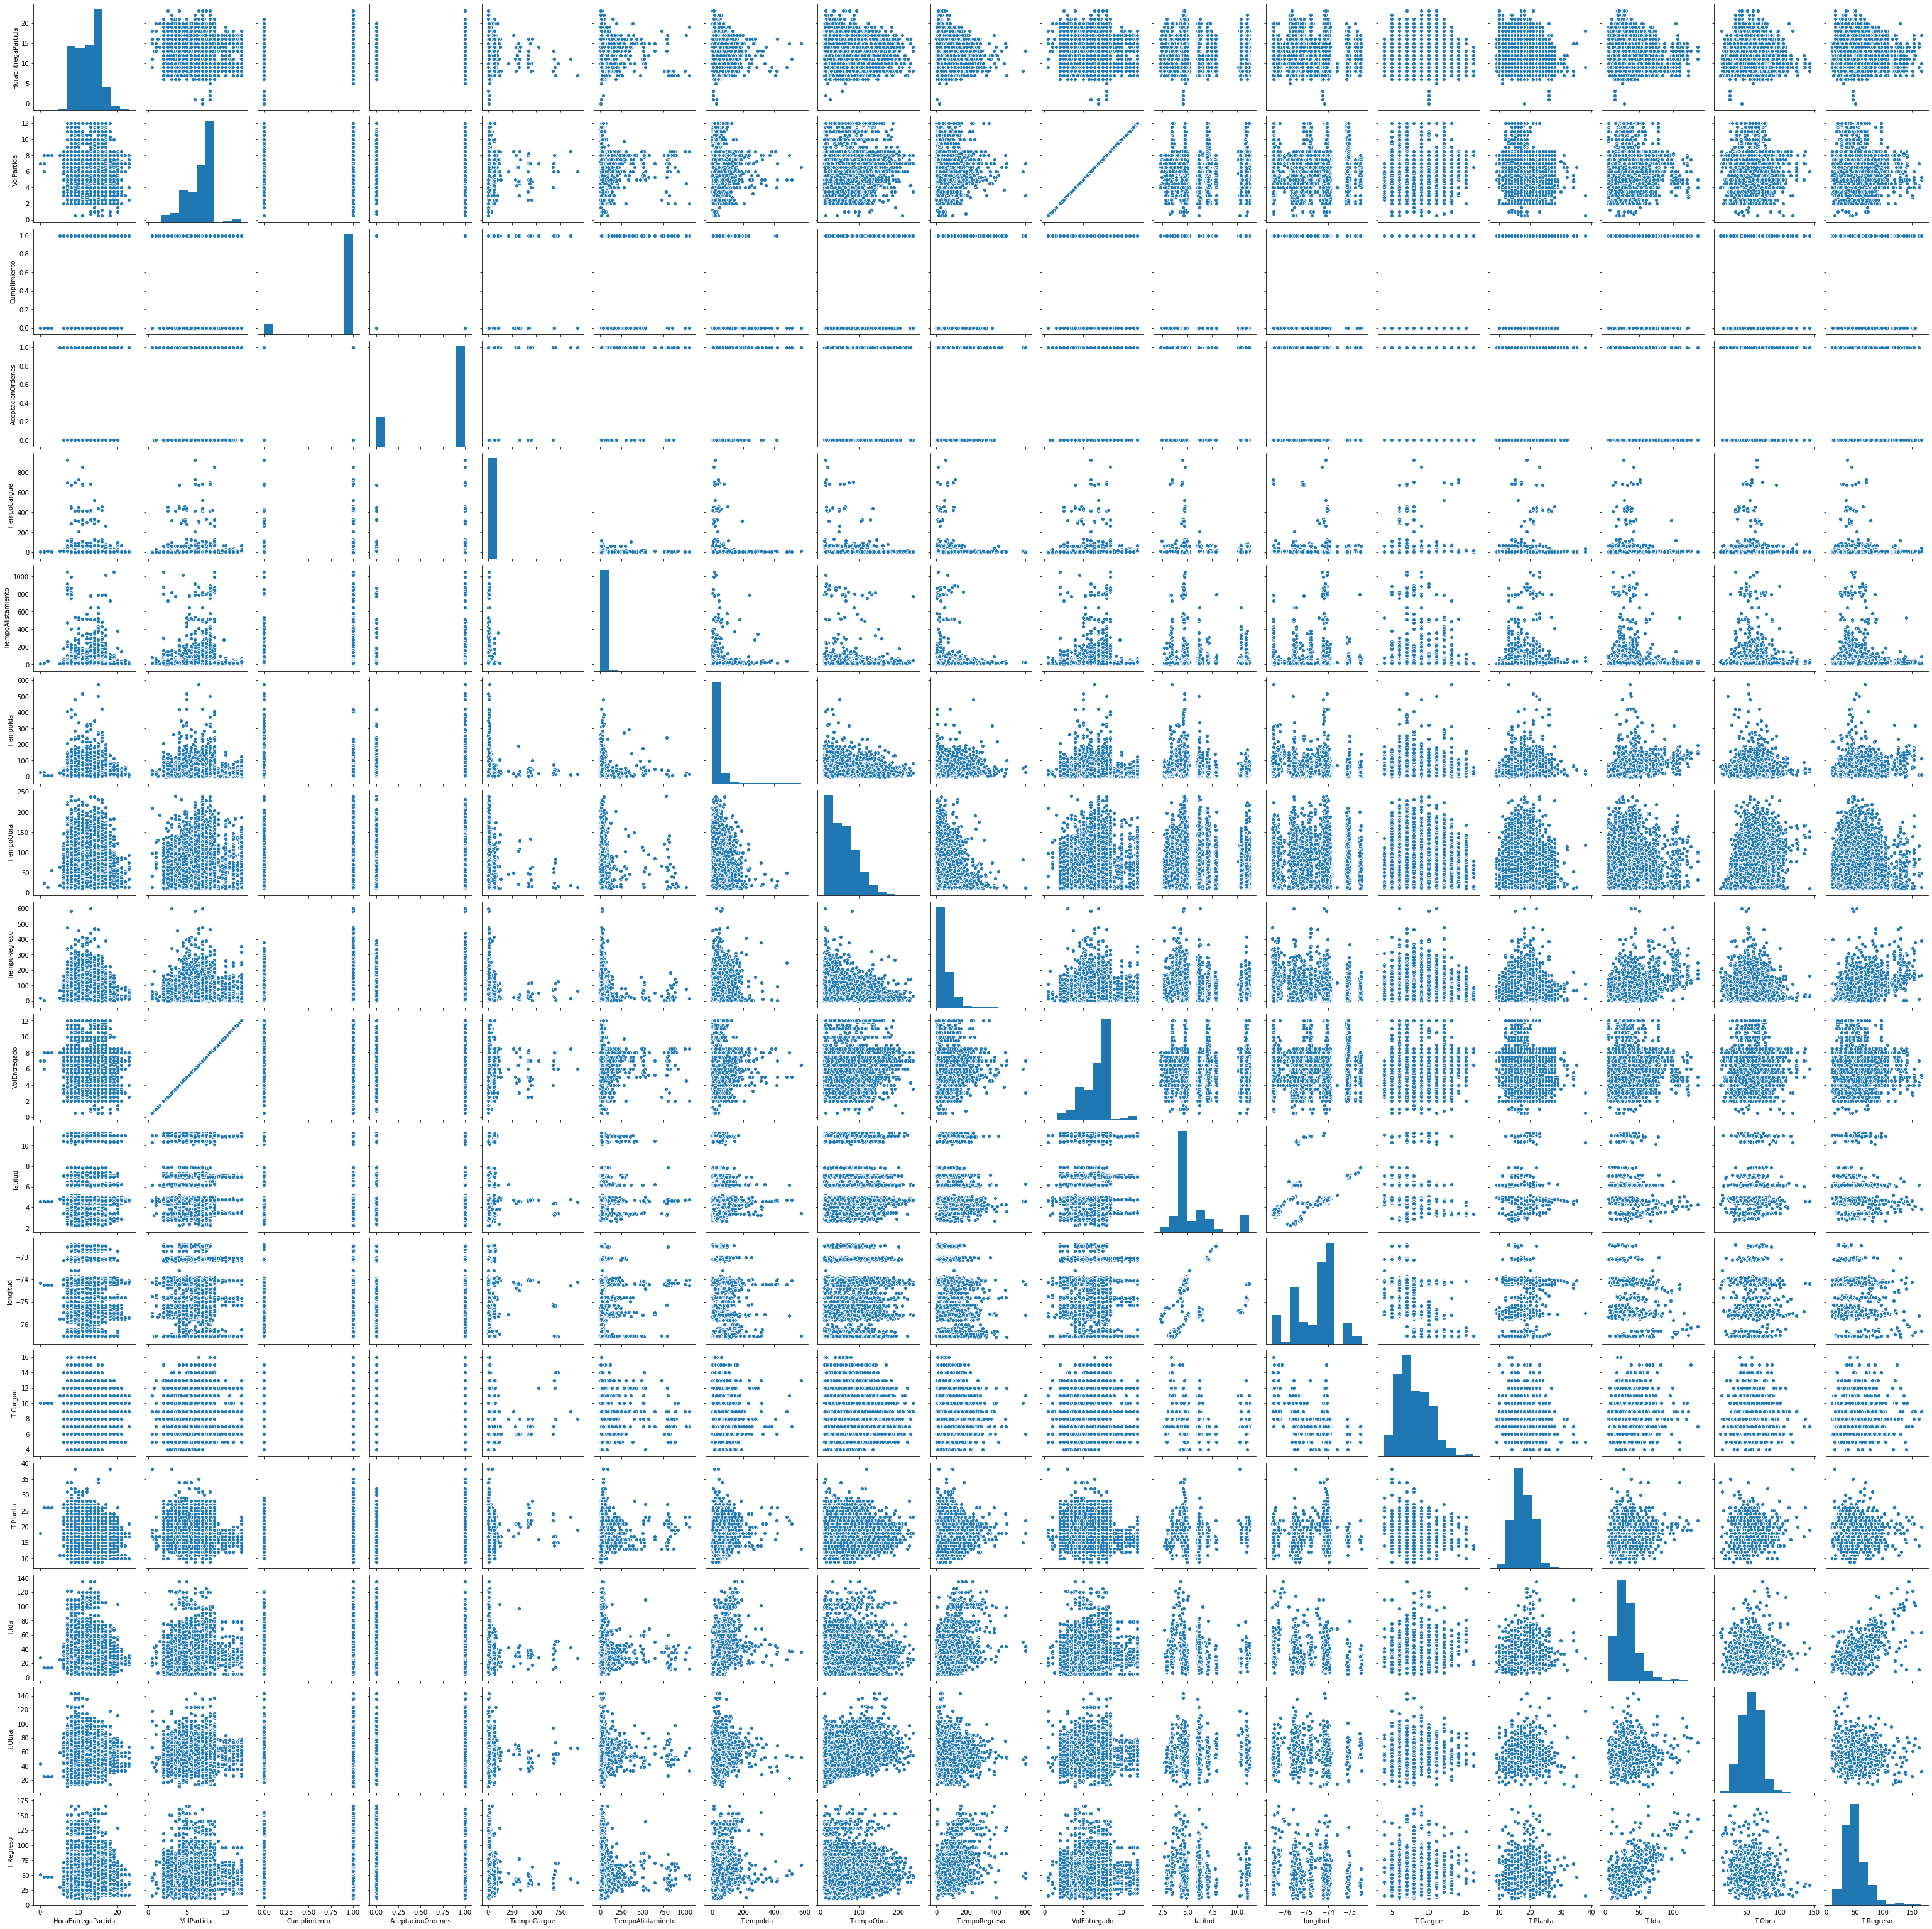

In [61]:
sns.pairplot(df_1[["HoraEntregaPartida","VolPartida","Cumplimiento","AceptacionOrdenes","TiempoCargue",
       'TiempoAlistamiento', 'TiempoIda', 'TiempoObra', 'TiempoRegreso',
       'VolEntregado', 'latitud', 'longitud', 'T.Cargue',
       'T.Planta', 'T.Ida', 'T.Obra', 'T.Regreso']])

In [58]:
df_1.columns

Index(['Pedido', 'servicio', 'Entrega', 'Estatus', 'EstatusPedido', 'Cluster',
       'Planta', 'TipoPlanta', 'Ciudad', 'Centro', 'NombreObra', 'Obra',
       'NombreCliente', 'Cliente_x', 'HrReq', 'HoraEntregaPartida',
       'FechaEntrega', 'TipoProducto', 'VolPartida', 'DistanciaPlantaObraKm',
       'Cumplimiento', 'AceptacionOrdenes', 'TiempoCargue',
       'TiempoAlistamiento', 'TiempoIda', 'TiempoObra', 'TiempoRegreso',
       'VolEntregado', 'CancelacionCliente', 'CancelacionCemex',
       'CancelacionOtros', 'TipoObra', 'latitud', 'longitud', 'T.Cargue',
       'T.Planta', 'T.Ida', 'T.Obra', 'T.Regreso', 'eTiempoCargue',
       'eTiempoAlistamiento', 'eTiempoIda', 'eTiempoObra', 'eTiempoRegreso'],
      dtype='object')

In [55]:
df_1.head().T

,0,1,2,3,4
Pedido,8010829224,8010829224,8010829224,8010829224,8010853509-S
servicio,L001,L002,L003,L004,L001
Entrega,190211873,190211880,190212815,190213437,190212116
Estatus,Normal,Normal,Normal,Normal,Normal
EstatusPedido,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera
Cluster,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE
Planta,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI
TipoPlanta,Central,Central,Central,Central,Central
Ciudad,Cali,Cali,Cali,Cali,Cali
Centro,F010,F010,F010,F010,F009


<h2>¿Cuantos viajes tienen un Error Absoluto menor al 10%?</h2>

In [35]:
# nueva columna, si aprueba el criterio es "1" si no es "0"
#Tiempo Ida
df_1['CriterioTiempoIda'] = df_1['eTiempoIda'].apply(lambda x: 1 if x <=0.1 else 0)

#Tiempo en Obra
df_1['CriterioTiempoObra'] = df_1['eTiempoIda'].apply(lambda x: 1 if x <=0.1 else 0)

In [36]:
#porcentaje de registros que superan el criterio
df_1['CriterioTiempoIda'].sum()/df_1['CriterioTiempoIda'].count()

0.24836215910839457

In [37]:
#porcentaje de registros que superan el criterio y que tienen registro diferente a NaN
df_1[df_1['eTiempoIda'] >= 0]['CriterioTiempoIda'].sum()/df_1[df_1['eTiempoIda'] >= 0]['CriterioTiempoIda'].count()

0.29114539034171855

In [38]:
#porcentaje de registros que tienen registros diferentes a NaN
df_1[df_1['eTiempoIda'] >= 0]['CriterioTiempoIda'].count()/df_1['CriterioTiempoIda'].count()

0.8530520054495484

In [39]:
baseline = df_1[df_1['eTiempoIda'] >=0 ].groupby('Planta')['CriterioTiempoIda'].agg(['sum','count']).reset_index()
baseline['baseline_TIda'] = baseline['sum']/baseline['count']
baseline = baseline.drop(['sum', 'count'], axis=1)

In [22]:
baseline2 = df_1[df_1['eTiempoObra'] >=0 ].groupby('Planta')['CriterioTiempoObra'].agg(['sum','count']).reset_index()
baseline2['baseline_TObra'] = baseline2['sum']/baseline2['count']
baseline2 = baseline2.drop(['sum', 'count'], axis=1)

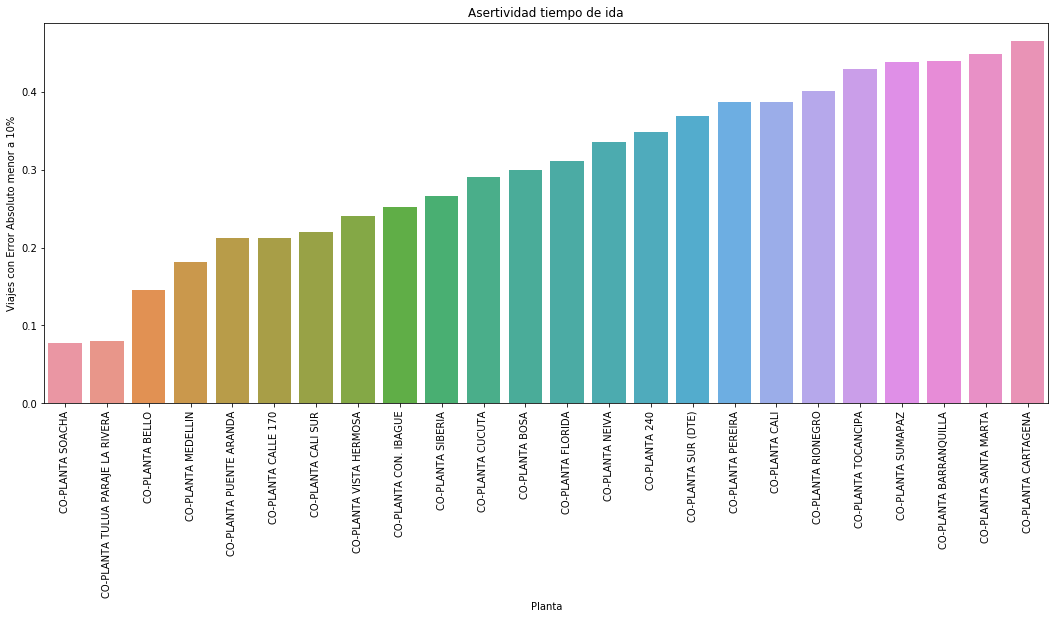

In [23]:
plt.figure(figsize=(18,7))

sns.barplot(x = baseline['Planta'], 
            y = baseline['baseline_TIda'], 
            data = baseline,
            order = baseline.sort_values('baseline_TIda')['Planta'])
 
plt.xlabel("Planta")
plt.ylabel("Viajes con Error Absoluto menor a 10%")
plt.title("Asertividad tiempo de ida")
plt.xticks(rotation=90)
plt.show()

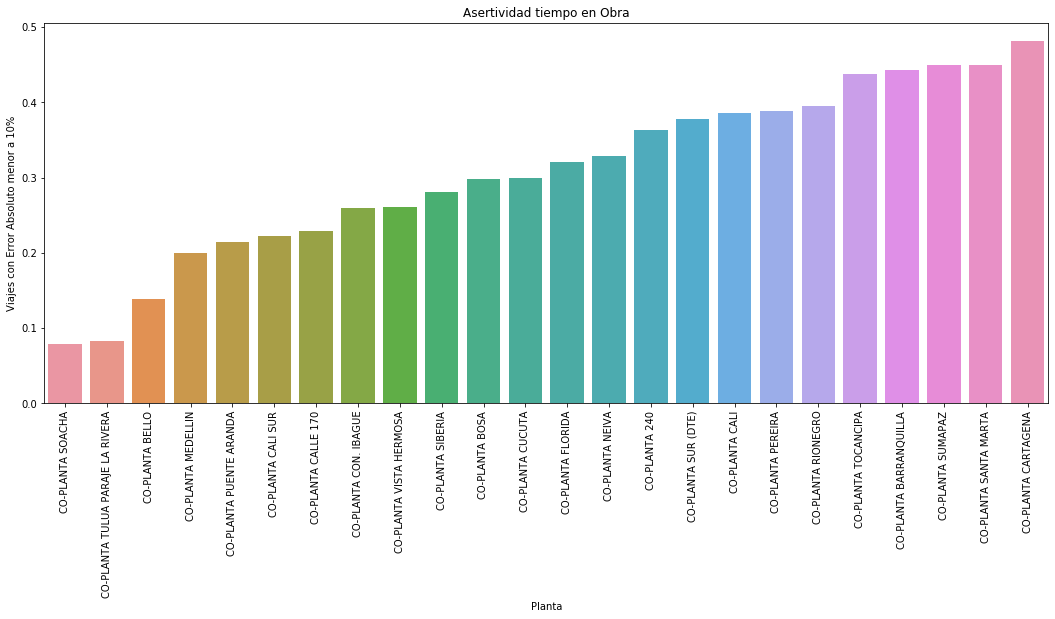

In [24]:
plt.figure(figsize=(18,7))

sns.barplot(x = baseline2['Planta'], 
            y = baseline2['baseline_TObra'], 
            data = baseline2,
            order = baseline2.sort_values('baseline_TObra')['Planta'])
 
plt.xlabel("Planta")
plt.ylabel("Viajes con Error Absoluto menor a 10%")
plt.title("Asertividad tiempo en Obra")
plt.xticks(rotation=90)
plt.show()

In [25]:
#Dataframe tabla con el primer consumo por obra
df_edadvolumen = querySQL( "{CALL SCAC_AP13_EdadVolumen (?,?,?)}" , (pais, '2021-01-01', '2021-09-30') )
df_edadvolumen

,Pais,Fecha,PrimerConsumo,Obra,Vol
0,Colombia,2021-01-02,2020-09-24,66896625,30.75
1,Colombia,2021-01-04,2017-12-28,66486172,7
2,Colombia,2021-01-04,2018-09-22,66574531,36.5
3,Colombia,2021-01-04,2018-12-01,FJL3,24
4,Colombia,2021-01-04,2019-09-25,66808387,5.25
...,...,...,...,...,...
11807,Colombia,2021-03-13,2021-02-22,66936273,2.25
11808,Colombia,2021-03-13,2021-03-12,66906916,7
11809,Colombia,2021-03-13,2021-03-13,66917140,29
11810,Colombia,2021-03-13,2021-03-13,66934602,9


In [54]:
#analisis de la edad del volumen
df_1 = pd.merge(df_1, df_edadvolumen[["Obra", "PrimerConsumo"]], how='left', left_on=['Obra'], right_on=['Obra'])
df_1['EdadVolumen_dias'] = (df_1['FechaEntrega'] - df_1["PrimerConsumo"]) / np.timedelta64(1,'D')
df_1.tail(20).T

KeyboardInterrupt: 

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

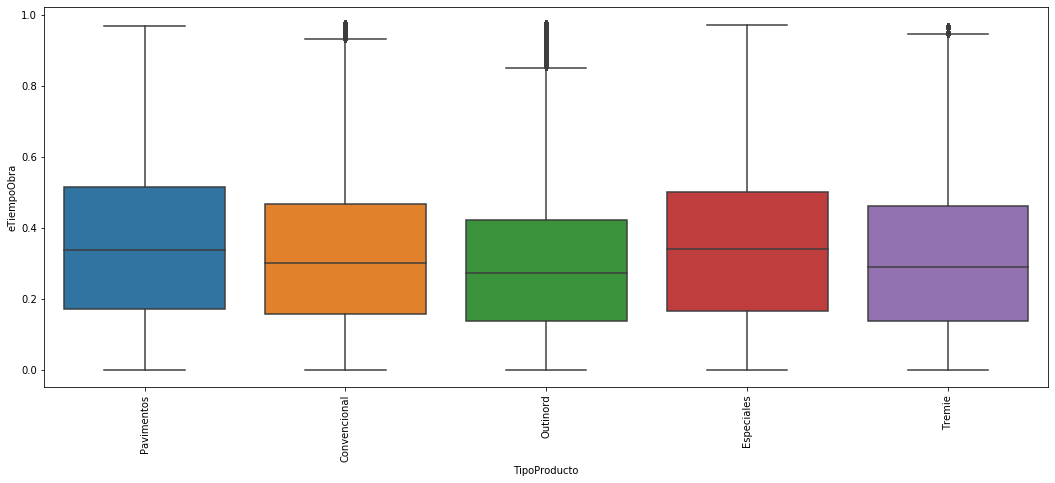

In [53]:
plt.figure(figsize=(18,7))
sns.boxplot(x='TipoProducto', y = 'eTiempoObra', data = df_1[(df_1['TiempoObra'] > 10) & (df_1['TiempoObra'] < 180) & (df_1['eTiempoObra'] < 1)])
plt.xticks(rotation=90)

Text(0.5, 1.0, 'La edad del volumen afecta el tiempo en obra?')

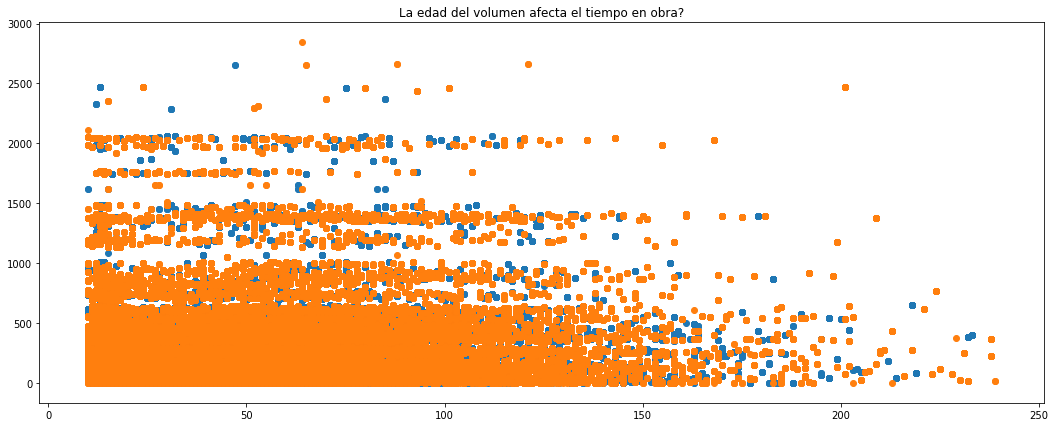

In [47]:
#grafico la dispersión de los datos
plt.figure(figsize=(18,7))
plt.scatter(df_1[df_1['CriterioTiempoObra'] == 1 ]['TiempoObra'], df_1[df_1['CriterioTiempoObra'] == 1 ]['EdadVolumen_dias'])

plt.scatter(df_1[df_1['CriterioTiempoObra'] == 0 ]['TiempoObra'], df_1[df_1['CriterioTiempoObra'] == 0 ]['EdadVolumen_dias'])

plt.title("La edad del volumen afecta el tiempo en obra?")


In [ ]:
edad_vs_criterioTObra = df_1.groupby('CriterioTiempoObra')['']

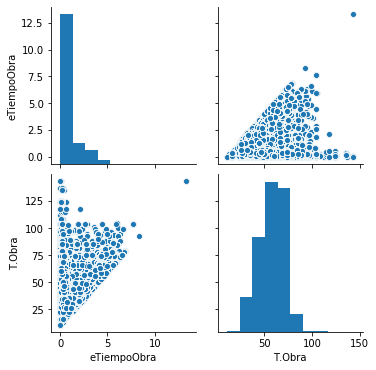

In [48]:
sns.pairplot(df_1[[ 'eTiempoObra', 'T.Obra']])

<h2>Tiempos de ciclo por distribucion de probabilidad</h2>

In [33]:
df['TiempoObra_porm3'] = df['TiempoObra']/df['VolPartida']

Text(-2.700000000000003, 0.5, 'Repeticiones')

<Figure size 1296x504 with 0 Axes>

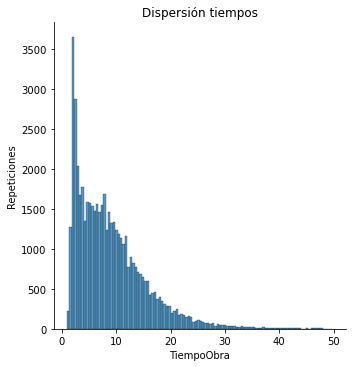

In [43]:
df_66783550 = df[df['TiempoObra_porm3'] < 50]

#cuento las repeticiones por cada componente
#df_count_time = df_66783550[(df_66783550['TiempoObra_porm3'] < 120) & (df['TiempoObra_porm3'] > 2)].groupby(['TiempoObra_porm3'])['Entrega'].agg(['count']).reset_index()
#df_count_time = df_66783550.groupby(['TiempoObra_porm3'])['Entrega'].agg(['count']).reset_index()
plt.figure(figsize=(18,7))

ax = sns.displot(df_66783550['TiempoObra_porm3'])
#grafico la dispersión de los datos
#plt.scatter(df_66783550['TiempoObra_porm3'], df_count_time['count'])
plt.title("Dispersión tiempos")
plt.xlabel('TiempoObra')
plt.ylabel("Repeticiones")

In [37]:
df_66783550['TiempoObra_porm3'].mean()


8.68191884905629